# FLGo中的横向联邦学习范式

这一节主要向大家介绍FLGo中是如何实现横向联邦流程的，并基于此说明如果要实现\复现算法，都要修改哪些对应的部分。

# 横向联邦范式示意图

假设大家看到这里前已经自行了解了联邦学习的基本流程，则下面将结合下图说明FLGo中的流程。

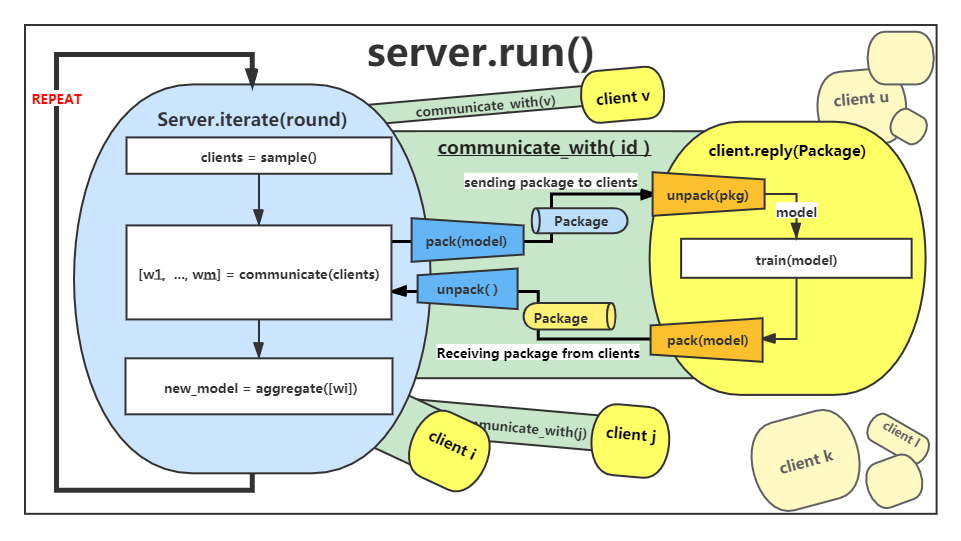

# Server端

## iterate ()

首先，FLGo的横向联邦中的Server有一个run函数，它使用一个for循环来迭代所有的通信轮数。在每次循环中，Server会首先调用自己的iterate方法。因此iterate方法就涵盖了服务器在一轮通信中的所有动作。iterate不接收输入，它的返回值是在这次迭代中模型是否被更新（Bool）。一个标准的iterate方法的标准实现如下（flgo.algorithm.fedbase.iterate）：

In [ ]:
    def iterate(self):
        """
        The standard iteration of each federated round that contains three
        necessary procedure in FL: client selection, communication and model aggregation.
        :param
        :return
        """
        # sample clients: MD sampling as default
        self.selected_clients = self.sample()
        # training
        models = self.communicate(self.selected_clients)['model']
        # aggregate: pk = 1/K as default where K=len(selected_clients)
        self.model = self.aggregate(models)
        return len(models)>0

iterate方法通常是最需要被修改的函数之一，因为不同算法的服务器通常会执行各式各样的额外操作，这里不过多赘述

## sample ()

在每个iterate中，服务器首先调用self.sample()进行采样，该方法的返回值必须是一个整型列表，表示的是被采样到的用户的索引（ID）。该采样函数默认实现包含全采样、MD采样、均匀采样，以及是否考虑当前用户可用性的变种（默认全体用户都是始终可用的，后面在系统异构性里会细讲）。采样函数的默认实现如下：

In [ ]:
    @ss.with_availability
    def sample(self):
        """Sample the clients.
        :param
        :return
            a list of the ids of the selected clients
        """
        all_clients = self.available_clients if 'available' in self.sample_option else [cid for cid in range(self.num_clients)]
        # full sampling with unlimited communication resources of the server
        if 'full' in self.sample_option:
            return all_clients
        # sample clients
        elif 'uniform' in self.sample_option:
            # original sample proposed by fedavg
            selected_clients = list(np.random.choice(all_clients, min(self.clients_per_round, len(all_clients)), replace=False)) if len(all_clients)>0 else []
        elif 'md' in self.sample_option:
            # the default setting that is introduced by FedProx, where the clients are sampled with the probability in proportion to their local data sizes
            local_data_vols = [self.clients[cid].datavol for cid in all_clients]
            total_data_vol = sum(local_data_vols)
            p = np.array(local_data_vols)/total_data_vol
            selected_clients = list(np.random.choice(all_clients, self.clients_per_round, replace=True, p=p)) if len(all_clients)>0 else []
        return selected_clients

采样策略近期逐渐成为联邦学习中的一个研究热点（也可能是只剩余温了），该函数被修改的频率也是比较高的。

## communicate (client_ids, mtype, asynchronous)

communicate方法负责一个完整的通信来回，也就是它把信息打包好后广播给选中的用户列表，然后返回这些用户所返回的包裹。communicate函数本身在绝大多数情形下，几乎不需要被修改。往往涉及通信流程和内容的变化所需要修改的只是communicate内部所调用的pack和unpack函数。这里贴出communicate的参数，仅讲解用法

In [ ]:
    def communicate(self, selected_clients, mtype=0, asynchronous=False):
        """
        The whole simulating communication procedure with the selected clients.
        This part supports for simulating the client dropping out.
        :param
            selected_clients: the clients to communicate with
            mtype: type of message
            asynchronous: asynchronous communciation or synchronous communcation
        :return
            :the unpacked response from clients that is created ny self.unpack()
        """
        ...

selected_clients为用户索引列表。mtype为消息类型，它主要用于决定打包函数Server.pack的返回，和用户本地响应的动作。asynchonous决定了communicate是否是异步的方式进行，如果是异步的方式进行，虚拟时钟将不会在当前时刻被阻塞，用户返回的包裹将会在未来某一个虚拟时刻到达，到达的延迟取决于用户自身。关于异步的情形也主要在后面的章节进行讨论。

在communicate函数中，主要是给要通信的用户用pack函数打包给他们的包裹，然后用communciate_with函数与它们通信，最后用函数unpack拆包它们发回的包裹。各种压缩\解压缩和加密\解密的操作可以在pack和unpack对中实现

## communicate_with (client_id, package)

相较于communicate函数，communicate_with用于点对点通信，而不是广播给一群用户后获取它们的返回。该函数主要在communicate中被调用，之所以封装成函数是因为可以在这里增加并行来提高效率。该函数需要被修改的频率也较低，故这里也只讲解用法。

In [ ]:
    def communicate_with(self, client_id, package={}):
        """
        Pack the information that is needed for client_id to improve the global model
        :param
            client_id: the id of the client to communicate with
            package: the package to be sended to the client
            mtype: the type of the message that is used to decide the action of the client
        :return
            client_package: the reply from the client and will be 'None' if losing connection
        """
        # listen for the client's response
        return self.gv.communicator.request(self.id, client_id, package)

该函数主要传入用户的id，以及发给它的包裹package。然后返回用户发回的包裹。包裹的形式都必须是字典。

## pack & unpack

pack和unpack定义了Server和Client的通信内容和通信流程。这里Server.pack和Client.unpack，Server.unpack和Client.pack构成了两组通信对，来描述通信中的收发行为。Server.pack&Client.unpack的默认实现如下：

In [ ]:
class Server:
    def pack(self, client_id, mtype=0, *args, **kwargs):
        """
        Pack the necessary information for the client's local training.
        Any operations of compression or encryption should be done here.
        :param
            client_id: the id of the client to communicate with
        :return
            a dict that only contains the global model as default.
        """
        return {
            "model" : copy.deepcopy(self.model),
        }
class Client:
        def unpack(self, received_pkg):
        """
        Unpack the package received from the server
        :param
            received_pkg: a dict contains the global model as default
        :return:
            the unpacked information that can be rewritten
        """
        # unpack the received package
        return received_pkg['model']

Server的pack函数主要用于负责把模型发给Client，因此使用深拷贝来获得模型的副本，来防止用户本地训练影响全局模型。用户也通过关键字'model'来获得包裹中的模型。

Server的unpack主要用于整理不同用户的包裹成数组的字典，Client的pack函数较为灵活，默认实现是发回训练好的本地模型，这俩实现如下

In [ ]:
class Server:
    def unpack(self, packages_received_from_clients):
        """
        Unpack the information from the received packages. Return models and losses as default.
        :param
            packages_received_from_clients:
        :return:
            res: collections.defaultdict that contains several lists of the clients' reply
        """
        if len(packages_received_from_clients)==0: return collections.defaultdict(list)
        res = {pname:[] for pname in packages_received_from_clients[0]}
        for cpkg in packages_received_from_clients:
            for pname, pval in cpkg.items():
                res[pname].append(pval)
        return res
        }
class Client:
    def pack(self, model, *args, **kwargs):
        """
        Packing the package to be send to the server. The operations of compression
        of encryption of the package should be done here.
        :param
            model: the locally trained model
        :return
            package: a dict that contains the necessary information for the server
        """
        return {
            "model" : model,
            }

## aggregate 

聚合函数虽然很重要，但因为相同的代码段可以放在iterate中去写，大多数时候该函数不需要重写甚至不需要被调用。该函数默认接收模型数组，返回聚合后的模型。值得一提的是FLGo中将所有nn.Module模型进一步封装成了FModule类，使不同的模型可以直接加减乘除，因此可以保证跟伪代码的一致性，使得实现idea更加方便。此外也提供了一些模型的算子，例如加权平均、取范数、拉成tensor等。

In [ ]:
    def aggregate(self, models: list, *args, **kwargs):
        """
        Aggregate the locally improved models.
        :param
            models: a list of local models
        :return
            the averaged result
        pk = nk/n where n=self.data_vol
        K = |S_t|
        N = |S|
        -------------------------------------------------------------------------------------------------------------------------
         weighted_scale                 |uniform (default)          |weighted_com (original fedavg)   |other
        ==========================================================================================================================
        N/K * Σpk * model_k             |1/K * Σmodel_k             |(1-Σpk) * w_old + Σpk * model_k  |Σ(pk/Σpk) * model_k
        """
        if len(models) == 0: return self.model
        local_data_vols = [c.datavol for c in self.clients]
        total_data_vol = sum(local_data_vols)
        if self.aggregation_option == 'weighted_scale':
            p = [1.0 * local_data_vols[cid] /total_data_vol for cid in self.received_clients]
            K = len(models)
            N = self.num_clients
            return fmodule._model_sum([model_k * pk for model_k, pk in zip(models, p)]) * N / K
        elif self.aggregation_option == 'uniform':
            return fmodule._model_average(models)
        elif self.aggregation_option == 'weighted_com':
            p = [1.0 * local_data_vols[cid] / total_data_vol for cid in self.received_clients]
            w = fmodule._model_sum([model_k * pk for model_k, pk in zip(models, p)])
            return (1.0-sum(p))*self.model + w
        else:
            p = [1.0 * local_data_vols[cid] / total_data_vol for cid in self.received_clients]
            sump = sum(p)
            p = [pk/sump for pk in p]
            return fmodule._model_sum([model_k * pk for model_k, pk in zip(models, p)])



# Client端 

对于每个被communicate_with的用户，flgo的通信器都会调用client的message_handler(package)函数来判断client执行哪个动作来响应。在横向联邦中，mtype的默认值是0，对应的client的动作是Client.reply，该映射关系被Client实例的actions属性所决定。

In [ ]:
class BasicClient(BasicParty):
    def __init__(self, option={}):
        ...
        self.actions = {0, self.reply}

## reply (server_package)

在被comunicate_with，所有被选中的用户都将执行他们本地的reply函数，reply函数就定义了横向联邦中用户收到包裹之后的行为。该函数的默认实现如下：

In [ ]:
    def reply(self, svr_pkg):
        """
        Reply to server with the transmitted package.
        The whole local procedure should be planned here.
        The standard form consists of three procedure:
        unpacking the server_package to obtain the global model,
        training the global model, and finally packing the updated
        model into client_package.
        :param
            svr_pkg: the package received from the server
        :return:
            client_pkg: the package to be send to the server
        """
        model = self.unpack(svr_pkg)
        self.train(model)
        cpkg = self.pack(model)
        return cpkg

reply方法接受服务器发过来的包裹(字典类型)，然后使用unpack函数拆包，获得模型，然后调用self.train函数进行本地训练，最后将必要信息(比如模型)进行打包，作为返回值。

## train (model)

本地训练方法与pytorch的训练范式基本是保持一致的。这里唯一特别之处在于：为了尽可能保证同一个训练pipeline对不同benchmark的一致性，把所有数据集相关的计算，模型前向的计算，交给了benchmark所指定的任务计算器来完成，因此在实现联邦算法时，就可以尽可能避开不同数据集的差异。而这部分差异的内容就留给实现benchmark的核心时来实现。默认的训练流程如下：

In [ ]:
    @fmodule.with_multi_gpus
    def train(self, model, *args, **kwargs):
        """
        Standard local training procedure. Train the transmitted model with local training dataset.
        :param
            model: the global model
        :return
        """
        model.train()
        optimizer = self.calculator.get_optimizer(model, lr = self.learning_rate, weight_decay=self.weight_decay, momentum=self.momentum)
        for iter in range(self.num_steps):
            # get a batch of data
            batch_data = self.get_batch_data()
            model.zero_grad()
            # calculate the loss of the model on batched dataset through task-specified calculator
            loss = self.calculator.compute_loss(model, batch_data)['loss']
            loss.backward()
            optimizer.step()
        return

train函数默认接收的第一个参数必须是模型。self.calculator是在构造函数中被初始化的，它的类型为TaskCalculator，来自所使用的benchmark模块。这里的get_optimizer、get_batch_data、compute_loss都是直接由calculator或是基于calculator来实现的。因此很多魔改本地训练目标函数的方法都可以通过修改train函数来实现。

# 总结

这里总结下FLGo中横向联邦算法的流程：
1. 服务器执行run方法，开启迭代；

2. 在每个迭代中，服务器执行iterate方法，来描述这一轮迭代的行为；

3. 迭代开始，服务器通过sample方法采样用户；

4. 服务器通过communicate方法与用户通信；

5. communciate方法中，服务器使用pack\unpack方法来定义通信的流程和内容，communicate方法将返回通信的结果；

6. 获取到通信的结果后，服务器使用聚合函数aggregate，来聚合模型；

7. 开启下一轮迭代。

由于每个环节基本都保证了独立性，在需要使用FLGo实现联邦算法时，所需要修改的代码量还是相对较少的。接下来将以几个经典FL算法为例子，讲解如何使用FLGo来实现算法